## Defactoring Pace of Change


The code expressed below has nine steps:
* [Importing Libraries](#Importing-Libraries) - Loads the necessary Python libraries needed for the analysis.
* [Setting Parameters](#Setting-Parameters) - Specifies parameters for the loading, cleaning, and labeling of data as well as sets conditions for the logistic regression.
* [Preparing Metadata](#Preparing-MetaData) - Generates a list of *.tsv files from the `poems/` directory. 
    * [Cleaning Metadata](#Cleaning-Metadata) - Loads the metadata file, `poemetadata.csv` and performs some cleaning of the metadata to make labeling easier.
    * [Sorting Training Data](#Sorting-Data) - Sort the volumes into two bins, reviewed and not reviewed using the cleaned metadata.
* [Transforming Words into Features](#Transforming-Words-into-Features) - Identifies the 3,200 most common words in the corpus. Those most common words will be the features for the regression.
    * [Filtering Authors](#Filtering-Authors) - Removes poems by authors who have been reviewed.
    * [Filtering Words](#Filtering-Words) - Remove any words from the poem data that are not in the most-common feature list.
* [Training Predictive Models](#Training-Predictive-Models) - Run a separate logistic regression for each volume, using a single volume as held-out data and measure each model's predictive power.
* [Modeling Coefficients](#Modeling-Coefficients) - Run a single logistic regression over all the data to inspect the salient coefficients.
* [Plotting Results](#Plotting-Results) - Generate a plot showing the accuracy of the predictive models.



### Importing Libraries

This section loads a series of libraries used in the Pace of Change analysis.

In [1]:
### DEFACTORING IMPORT
import os
import csv 
import random 
from collections import Counter 

import numpy as np 
import pandas as pd 

from multiprocessing import Pool 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.linear_model import LogisticRegression

We begin examination of the code by importing a series of Python libraries into working memory. This is the boundary between the layers of bespoke code and existing general purpose (os, csv, random) and scientific computing libraries (numpy, pandas, sklearn). Following from Hinsen’s model of layers of scientific software, what is missing is the inclusion of libraries from the *disciplinary* layer. The most specific library in terms of use in the Hinsen model is the LogisticRegression model from Scikit-Learn, but we’d argue this lives in layer two, scientific software, because it  is broadly applicable across a variety of disciplines. This begs the question, what or where are the disciplinary Python libraries for literary history or digital humanities? What functions would the perform? What domain specific tasks or methods need to encoded into a disciplinary library? Perhaps it is too early for such libraries to exist as the practices of computational and data intensive research are still new (in literary history).

### Setting Parameters

The first section of the code sets a series of parameters specifying what data to process, where data are located, and parameters for the logistic regression. While there is no complex logic or work being done in this section, many assumptions and important distinctions that shape the execution of subsequent code are defined here.

In [2]:
## PATHS.

sourcefolder = 'poems/'
extension = '.poe.tsv'
classpath = 'poemeta.csv'
outputpath = 'mainmodelpredictions.csv'

## EXCLUSIONS.

excludeif = dict()
excludeif['pubname'] = 'TEM'
# We're not using reviews from Tait's.

excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.

excludeifnot = dict()
excludeabove = dict()
excludebelow = dict()

excludebelow['firstpub'] = 1700
excludeabove['firstpub'] = 1950
sizecap = 360

# For more historically-interesting kinds of questions, we can limit the part
# of the dataset that gets TRAINED on, while permitting the whole dataset to
# be PREDICTED. (Note that we always exclude authors from their own training
# set; this is in addition to that.) The variables futurethreshold and
# pastthreshold set the chronological limits of the training set, inclusive
# of the threshold itself.

## THRESHOLDS

futurethreshold = 1925
pastthreshold = 1800

# CLASSIFY CONDITIONS

positive_class = 'rev'
category2sorton = 'reviewed'
datetype = 'firstpub'
numfeatures = 3200
regularization = .00007


paths = (sourcefolder, extension, classpath, outputpath)
exclusions = (excludeif, 
              excludeifnot, 
              excludebelow, 
              excludeabove, 
              sizecap)
thresholds = (pastthreshold, 
              futurethreshold)
classifyconditions = (category2sorton, 
                      positive_class, 
                      datetype, 
                      numfeatures, 
                      regularization)

The parameters defined in the code cell above are a set of knobs and switches used to tweak the performance and execution of the computational modeling process. Underwood and Sellers have collected the parameters into four categories: *paths*, *exclusions*, *thresholds*, and *classifyconditions*. These categories are simultaneously distinguished discursively through the code comments (the lines beginning with a #) and technologically through four variable assignments, `exclusions`, `thresholds`, and `classifyconditions`. Because technically speaking the grouping of parameters is not strictly necessary, each of these four variables embody stylistic choices of the authors as a means of organizing and structuring the information they are encoding in Python.    

The variables in `paths` specify the location of the data and metadata files as well as where to write the output files at the completion of the analysis. The variables in `exclusions` specify data and types of data to be excluded from the analysis, such as reviews from *Tait's Endinburgh Magazine* (https://en.wikipedia.org/wiki/Tait%27s_Edinburgh_Magazine), which we infer from the author's comments. Additional exclusions specify temporal boundaries from 1700 to 1950. A further set of two variables in `thresholds` also articulates a temporal boundary from 1800 to 1925. The comments indicate this distinguishes the temporal window for datasets using in *training* versus those used during *prediction.* The variables in `classifyconditions` are important parameters for the logistic regression, specifying the number of variables to train the model upon as well as setting the regularization parameter (`regularization`) for the logistic regression. What is not well documented here, is why the value .00007 was chosen over other values.


### Preparing Metadata

With the preparation of metadata we begin to see some logical work of Pace of Change being conducted. The code in this section has two subsections, one to clean the metadata and another to sort the training data. All of the work in this section focuses on preparing the metadata, identified in the `classpath` variable and the filenames of the individual data files in the `sourcefolder`. The main task of this section is to organize the metadata of the volumes and their associated labels (positive or negative) for training the logistic regression. All of the code in this section attends to the cleanliness of the metadata; we will not start digging into the data itself until the next section.

In [3]:
### DEFACTORING FUNCTION
### def create_model(paths, exclusions, thresholds, classifyconditions):
''' This is the main function in the module.
It can be called externally; it's also called
if the module is run directly.
'''
verbose = False

if not sourcefolder.endswith('/'):
    sourcefolder = sourcefolder + '/'

# This just makes things easier.

# Get a list of files.
allthefiles = os.listdir(sourcefolder)
# random.shuffle(allthefiles)

volumeIDs = list()
volumepaths = list()

for filename in allthefiles:

    if filename.endswith(extension):
        volID = filename.replace(extension, "")
        # The volume ID is basically the filename minus its extension.
        # Extensions are likely to be long enough that there is little
        # danger of accidental occurrence inside a filename. E.g.
        # '.fic.tsv'
        path = sourcefolder + filename
        volumeIDs.append(volID)
        volumepaths.append(path)

This code assembles a list of volume identifiers (`volumeIDs`) and file paths (`volumepaths`) by readings the directory listing of files in the `poems/` directory (`sourcefolder`). The filenames are in and of themselves a source of metadata, but as we will see in the code below, they need to be reconciled with the metadata stored separately from the data files. 

We are curious about the contents of the `volumeIDs` and `volumepaths` variables. 

In [4]:
### DEFACTORING INSPECTION
### Inspect the two variables defined in the codecell above.
### We know they are lists so lets just look at the first item.
print("The first item in volumeIDs is: ", volumeIDs[0])
print("The first item in volumepaths is: ",volumepaths[0])

The first item in volumeIDs is:  loc.ark+=13960=t5n881k59
The first item in volumepaths is:  poems/loc.ark+=13960=t5n881k59.poe.tsv


The code has created an alignment between identifiers in the metadata records and the filename identifiers of the TSV data files themselves (located in the `poems/` folder). These identifiers, `dul1.ark+=13960=t5fb5xg2z`, are the threads that stitch together the various representations of the (meta)data.

#### Cleaning Metadata

In [5]:
### DEFACTORING FUNCTION DEFINITION
### we need these helper functions for execute the next code cell

def dirty_pairtree(htid):
    period = htid.find('.')
    prefix = htid[0:period]
    postfix = htid[(period+1): ]
    if '=' in postfix:
        postfix = postfix.replace('+',':')
        postfix = postfix.replace('=','/')
    dirtyname = prefix + "." + postfix
    return dirtyname

def forceint(astring):
    try:
        intval = int(astring)
    except:
        intval = 0

    return intval

This code cell defines two functions used in the code below. The first is `dirty_pairtree()`, which cleans up the identifiers in the data. This issue arises from the fact that the HathiTrust (where Underwood and Sellers got their data from) uses IDs that cannot be expressed on the filesystem and Underwood and Sellers encoded ID metadata in filenames. The “/” and “:” characters in the IDs cannot be part of a file name. So, because the volumes are stored as individual files they have a “+” and an “=” instead. However, the IDs are stored in the original format in the metadata file so the IDS have to be transformed back into the original HathiTrust format.  The second function is called `forceint()` and transforms numbers expressed as Python strings into the python integer data type with a bit of error handling in the case values that throw and error when being cast as an integer.

What does the the metadata look like? We can inspect the beginning of file to get a sense of the material conditions of the metadata.

In [6]:
### DEFACTORING INSPECTION
metadata_file = pd.read_csv(classpath)
#print(metadata_file.shape)
print("The metadata files has {} rows and {} columns.".format(
    *metadata_file.shape))
metadata_file.head()

The metadata files has 728 rows and 22 columns.


docid actualdate  inferreddate  firstpub    recept  \
0  loc.ark+=13960=t8sb4zz1q       1921          1921      1921  addcanon   
1              uc1.b3342759       1919          1919      1919    random   
2              uc1.b4100590       1918          1918      1918  reviewed   
3              uc1.b3340220       1918          1918      1918  reviewed   
4  uc2.ark+=13960=t0ft8gj1k       1918          1918      1918  reviewed   

    recordid        OCLC             author  \
0   537314.0         NaN    Lawrence, D. H.   
1  7930862.0         NaN  Wigren, Bessie C.   
2  6154122.0   2143179.0       Waugh, Alec,   
3  7917249.0  12688503.0    Nightingale, M.   
4  7657411.0   2518108.0   Faber, Geoffrey,   

                                             imprint enumcron  ...  judge  \
0                          New York;T. Seltzer;1921.      NaN  ...    NaN   
1                 Boston;The Poet Lore Company;c1919      NaN  ...    NaN   
2                           London;G. Richards;1918.      NaN  ...    NaN   
3           Oxford [Oxfordshire;B.H. Blackwell;1918.      NaN  ...    neg   
4  Oxford;B. H. Blackwell;New York;Longmans, Gree...      NaN  ...    NaN   

  impaud   yrrev pubname  birth gender nationality othername notes canon  
0    NaN     NaN     NaN   1885      m          uk       NaN   NaN     y  
1    NaN     NaN     NaN   1874      f          us       NaN   NaN   NaN  
2    NaN  1918.0     EGO   1898      m          uk       NaN   NaN   NaN  
3    NaN  1919.0     EGO   1879      f          uk       NaN   NaN   NaN  
4    NaN  1918.0     EGO   1889      m          uk       NaN   NaN   NaN  

[5 rows x 22 columns]

Using *defactoring inspection* we can actually look at the metadata file and inspect the first five rows of metadata. By blending the original code with our inspection code and narrative the metadata becomes less of a conceptual abstraction and more of a tangible, material object that we can interrogate. Here we can see the file has 728 rows and 22 columns as well as the contents of the first five rows.

In [7]:
### DEFACTORING FUNCTION 
### def get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove):
'''
As the name would imply, this gets metadata matching a given set of volume
IDs. It returns a dictionary containing only those volumes that were present
both in metadata and in the data folder.

It also accepts four dictionaries containing criteria that will exclude volumes
from the modeling process.
'''
print(classpath)
metadict = dict()

with open(classpath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)

    anonctr = 0

    for row in reader:
        volid = dirty_pairtree(row['docid'])
        theclass = row['recept'].strip()

        # I've put 'remove' in the reception column for certain
        # things that are anomalous.
        if theclass == 'remove':
            continue

        bail = False
        for key, value in excludeif.items():
            if row[key] == value:
                bail = True
        for key, value in excludeifnot.items():
            if row[key] != value:
                bail = True
        for key, value in excludebelow.items():
            if forceint(row[key]) < value:
                bail = True
        for key, value in excludeabove.items():
            if forceint(row[key]) > value:
                bail = True

        if bail:
            print("DEFACTORING: Excluding volume with id "+volid) ### DEFACTORING CODE
            continue

        birthdate = forceint(row['birth'])

        pubdate = forceint(row['inferreddate'])

        gender = row['gender'].rstrip()
        nation = row['nationality'].rstrip()

        #if pubdate >= 1880:
            #continue

        if nation == 'ca':
            nation = 'us'
        elif nation == 'ir':
            nation = 'uk'
        # I hope none of my Canadian or Irish friends notice this.

        notes = row['notes'].lower()
        author = row['author']
        if len(author) < 1 or author == '<blank>':
            author = "anonymous" + str(anonctr)
            anonctr += 1

        title = row['title']
        canon = row['canon']

        # I'm creating two distinct columns to indicate kinds of
        # literary distinction. The reviewed column is based purely
        # on the question of whether this work was in fact in our
        # sample of contemporaneous reviews. The obscure column incorporates
        # information from post-hoc biographies, which trumps
        # the question of reviewing when they conflict.

        if theclass == 'random':
            obscure = 'obscure'
            reviewed = 'not'
        elif theclass == 'reviewed':
            obscure = 'known'
            reviewed = 'rev'
        elif theclass == 'addcanon':
            print("DEFACTORING: adding volume") ### DEFACTORING CODE
            obscure = 'known'
            reviewed = 'addedbecausecanon'
        else:
            print("Missing class" + theclass)

        if notes == 'well-known':
            obscure = 'known'
        if notes == 'obscure':
            obscure = 'obscure'

        if canon == 'y':
            if theclass == 'addcanon':
                actually = 'Norton, added'
            else:
                actually = 'Norton, in-set'
        elif reviewed == 'rev':
            actually = 'reviewed'
        else:
            actually = 'random'

        metadict[volid] = dict()
        metadict[volid]['reviewed'] = reviewed
        metadict[volid]['obscure'] = obscure
        metadict[volid]['pubdate'] = pubdate
        metadict[volid]['birthdate'] = birthdate
        metadict[volid]['gender'] = gender
        metadict[volid]['nation'] = nation
        metadict[volid]['author'] = author
        metadict[volid]['title'] = title
        metadict[volid]['canonicity'] = actually
        metadict[volid]['pubname'] = row['pubname']
        metadict[volid]['firstpub'] = forceint(row['firstpub'])

# These come in as dirty pairtree; we need to make them clean.

cleanmetadict = dict()
allidsinmeta = set([x for x in metadict.keys()])
allidsindir = set([dirty_pairtree(x) for x in volumeIDs])
missinginmeta = len(allidsindir - allidsinmeta)
missingindir = len(allidsinmeta - allidsindir)
print("We have " 
      + str(missinginmeta) 
      + " volumes in missing in metadata, and")
print(str(missingindir) + " volumes missing in the directory.")
print(allidsinmeta - allidsindir)

for anid in volumeIDs:
    dirtyid = dirty_pairtree(anid)
    if dirtyid in metadict:
        cleanmetadict[anid] = metadict[dirtyid]

# Now that we have a list of volumes with metadata, we can select the groups of IDs
# that we actually intend to contrast. If we want to us more or less everything,
# this may not be necessary. But in some cases we want to use randomly sampled subsets.

# The default condition here is

# category2sorton = 'reviewed'
# positive_class = 'rev'
# sizecap = 350
# A sizecap less than one means, no sizecap.

### DEFACTORING FUNCTION CALL
### IDsToUse, classdictionary = metafilter.label_classes(metadict, category2sorton, positive_class, sizecap)

### DEFACTORING NAMESPACE 
metadict = cleanmetadict  # put the data into the global namespace so execution can continue.

poemeta.csv
DEFACTORING: Excluding volume with id loc.ark:/13960/t8sb4zz1q
DEFACTORING: Excluding volume with id mdp.39015013402501
DEFACTORING: Excluding volume with id mdp.39015011913525
DEFACTORING: Excluding volume with id hardywessexpoems189.hardywessexpoems1898
DEFACTORING: Excluding volume with id gerardmhopkins191.gerardmhopkins1918
DEFACTORING: Excluding volume with id loc.ark:/13960/t3fx82c2q
DEFACTORING: Excluding volume with id emilydickinso.emilydickinson
DEFACTORING: Excluding volume with id ellisbell184.ellisbell1848
We have 8 volumes in missing in metadata, and
0 volumes missing in the directory.
set()


This above code cell is large due to a long `for` loop processing each row of the metadata file. At a high level, the code in this cell loads the metadata and determines which volumes to exclude in the analysis. It does this by loading the poemeta.csv file and excluding rows based upon the parameters specified in the `excludeif`, `excludeifnot`, `excludeabove`, and `excludebelow` variables. This process removed 8 volume designations from the (meta)data. The resulting output immediately above is a mixture of the author’s code and our own DEFACTORING inspection statements (marked with the comment ### DEFACTORING). We have added a print statement so we can see the IDs of the volumes being excluded in the code.

Beyond filtering out excluded (meta)data, this code also makes a series of normalizing decisions, that is, there are more conceptual distinctions being made (or unmade) in this code. First is the normalization of nationality, which is a clinical way of saying Underwood and Sellers lump Canada with the United States and Ireland with the UK. Nationality is not a factor in the Pace of Change analysis, but it is interesting to see this code here, it implies this code was used in other explorations of the data. Additionally, this code cell splits the `recept` column of the metadata file into two columns, `obscure` and `reviewed`. From what we can tell from the code and the comments, there are poems that were reviewed, and there are poems that were too obscure. Lastly, there are poems that are not in the set of reviewed poems but are nevertheless part of the canon. In the latter case the poems are set to be “known” `(obscure = 'known')`. According to the author's comment this trumps the conflict when the author is known but not explicitly in the reviewed set.

We know that poems with the addcanon in the `recept` column are being excluded because they are included in the `excludeif` dictionary. But why? The code in the code cell above provides somewhat of an explanation:

```
excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.
```
What might be important to note here is how "great debates" in literary history about literary prestige, obscurity, and the canon are being ascribed in the code without much fanfare. There is a hard decision being made (in the blink of an eye) about the status of particular literary works. Most of these are, we suspect, fairly uncontroversial distinctions that accord with the broader community, but the code and computation enforce clear and unambiguous decisions for each an every volume. These hard decisions are pragmatically necessary to get to more interesting analysis.

In [8]:
### DEFACTORING INSPECTION
# Examine the original metadata file 

defactoring_volume_id = 'wu.89099921512'

the_croakers_metadata = (
    metadata_file
    .loc[metadata_file['docid'] == defactoring_volume_id]
    .squeeze()
    .sort_index()
)
the_croakers_metadata

OCLC                                         NaN
actualdate                                  1860
author                     Drake, Joseph Rodman,
birth                                       1795
canon                                        NaN
docid                             wu.89099921512
enumcron                                     NaN
firstpub                                    1860
gender                                         m
impaud                                       NaN
imprint         New York;The Bradford Club;1860.
inferreddate                                1860
judge                                        NaN
nationality                                   us
notes                                        NaN
othername                                    NaN
pubname                                      NaN
pubrev                                       NaN
recept                                    random
recordid                              8.9986e+06
title               

In [9]:
### DEFACTORING INSPECTION
# Examine the cleaned metadata
cleanmetadict[defactoring_volume_id]

{'author': 'Drake, Joseph Rodman,',
 'birthdate': 1795,
 'canonicity': 'random',
 'firstpub': 1860,
 'gender': 'm',
 'nation': 'us',
 'obscure': 'obscure',
 'pubdate': 1860,
 'pubname': '',
 'reviewed': 'not',
 'title': 'The croakers'}

The inspection above shows the data expressed in the CSV file has been transformed into into a Python dictionary, `cleanmetadict`, with additional columns for expressing more granularity about the categorizations for each poetry volume. We also observe the raw metadata csv file has additional columns that are not reflected in the Python dictionary. What we see reflected in `cleanmetadict` is only the metadata necessary for the analysis with any dirty or unnecessary information removed. Furthermore, the metadata now lives in a native Python data structure, a dictionary, making it easier to access specific volumes and manipulate in code.

#### Sorting Training Data

In [10]:
### DEFACTORING FUNCTION
### def label_classes(metadict, category2sorton, positive_class, sizecap):
''' This takes as input the metadata dictionary generated
by get_metadata. It subsets that dictionary into a
positive class and a negative class. Instances that belong
to neither class get ignored.
'''

all_instances = set([x for x in metadict.keys()])

# The first stage is to find positive instances.

all_positives = set()

for key, value in metadict.items():
    if value[category2sorton] == positive_class:
        all_positives.add(key)

This block of code reads the metadata properties and puts a subset of all entries into a variable, `all_positives`, which will contain all of the volume ids for reviewed poems. If the `reviewed` column has a value of ‘rev’, then it is selected for inclusion. The name and value of the property are parameterized however, so technically it is more correct, but more opaque as well, to state: if a poem’s metadata has the value 'rev' (specified by the `positive_class` variable) for the reviewed property (specified by the `category2sorton` variable) then it is labeled as a positive. Having thus collected all the reviewed poems into the set named `all_positives`, the next cell populates the variable `all_negatives` with all the instances not in the positive set by subtracting the set of positives from the set of all instances by applying a basic mathematical set operation (-).

In [11]:
all_negatives = all_instances - all_positives
iterator = list(all_negatives)
for item in iterator:
    if metadict[item]['reviewed'] == 'addedbecausecanon':
        all_negatives.remove(item)

The negative labels are assigned to all instances that are not in the set of positive instances. This section includes additional code that filters out any item with `addedbecausecannon` set for the `reviewed` property, but this code should never execute because, as we have seen above, the canon should already be removed.

In [12]:
if sizecap > 0 and len(all_positives) > sizecap:
    positives = random.sample(all_positives, sizecap)
else:
    positives = list(all_positives)
    print(len(all_positives))

# If there's a sizecap we also want to ensure classes have
# matching sizes and roughly equal distributions over time.

numpositives = len(all_positives)

if sizecap > 0 and len(all_negatives) > numpositives:
    if not 'date' in category2sorton:
        available_negatives = list(all_negatives)
        negatives = list()

        for anid in positives:
            date = metadict[anid]['pubdate']

            available_negatives = sort_by_proximity(available_negatives, 
                                                    metadict, date)
            selected_id = available_negatives.pop(0)
            negatives.append(selected_id)

    else:
        # if we're dividing classes by date, we obvs don't want to
        # ensure equal distributions over time.

        negatives = random.sample(all_negatives, sizecap)

else:
    negatives = list(all_negatives)

360


Most of the code in the cell above does not actually execute because the number of entries in the `all_positives` and `all_negatives` lists are not greater than `sizecap`. The conditional statements on line 1 and line 12 will not be true so the the accompanying blocks of code never execute. If the `sizecap` variable was smaller, or the number of entries larger, this code would use random sampling to select smaller number of entries from the positives entries.

Looking at the block of code for the negative entries is a bit more interesting. This block of code (from lines 13 to 29) makes an unexecuted reference to a function `sort_by_proximity` that samples from the negative elements with an equal distribution based upon some function of proximity. Because this code is not executing we are not going to spend more time and analytical attention to exactly how this function operates. Furthermore, we have not included the code for `sort_by_proximity()` in the notebook because it is not part of the execution path we are tracing. In the code’s garden of forking paths, this is a path not taken.

These issues of code that is not executed and functions that are not called point to properties of code that make it complex and therefore difficult to review or critique. Code has a textual and a processual dimension (Hiller 2015, Van Zundert 2016). The code-as-text is what we can see and read in the source code, the processual dimension of code is tied to its execution as a software program. Code critique moves in between these two modes of existence of code. We are here, as code critics, not simply looking at code-as-text. That is, we are in this case reviewing a *live* execution of the code. This is extremely significant and, we’d argue, distinguishes defactoring as more than analysing code-as-text; we are analyzing the code, the data, and their interaction in the computation. Leveraging the affordances of the Jupyter notebook platform allow us the ability to interact with the execution environment described in the code. At each step of the incremental process building this environment we can ask it questions by inspecting the state of variables (or even change them). This is more than simply treating the code as a text, the code is but one part of a complex assemblage we have been manipulating with the authors’ code (and some of our own). However, it is also not a complete inspection of all the ways in which the code can be possibly executed. As we *defactor* the authors’s code, we make choices about how much of the code to include for the argument we are trying to make (and for the sake of our time and attention). Thus we are dealing with a code-criticism conundrum: What is the required or adequate breadth and depth of the representation of the code, and subsequently of the critique? The decision to include or not include `sort_by_proximity()` is a breadth issue. How broad should we be in including code that does not execute? Note that we are including code from a conditional block that does not execute, but are not going out the additional step to include non-executed functions defined elsewhere in the code. The decision to include or not include code from the standard library, code not written by the authors, is a depth issue. While there are many functions we are stepping over, like `len`, `list`, `append`, `pop`, `random.sample`, we argue there is no need to step into these functions because, following Hinsen's model, they are not part of the bespoke code of Pace of Change. Again, this raises the problematic issue of our decision to step over `sort_by_proximity()` even though it was written by the authors' for this particular project.

Obviously the ‘rules of the game’ for defactoring are not quite clear yet. Therefore we are more or less ‘feeling’ our way through an emerging methodology for code criticism. As we see vestiges of the authors’ evolution in thinking in their code, this notebook is capturing the evolution of our thinking about defactoring as a practice.


In [13]:
# Now we have two lists of ids.

IDsToUse = set()
classdictionary = dict()

print()
print("We have " + str(len(positives)) + " positive, and")
print(str(len(negatives)) + " negative instances.")

for anid in positives:
    IDsToUse.add(anid)
    classdictionary[anid] = 1

for anid in negatives:
    IDsToUse.add(anid)
    classdictionary[anid] = 0

for key, value in metadict.items():
    if value['reviewed'] == 'addedbecausecanon':
        print("DEFACTORING: Adding cannon supplement") ### DEFACTORING CODE
        IDsToUse.add(key)
        classdictionary[key] = 0
# We add the canon supplement, but don't train on it.


We have 360 positive, and
360 negative instances.


In this cell we are seeing yet another instance of metadata being shaped and transformed in preparation for analysis. The code first prints out the number of positive and negative instances by checking the length (using `len()`) of the volume ids stored in the `positives` and `negatives` variables. Two loops iterate over these lists and populate two more variables, `IDsToUse` and `classdictionary`. The first, `IDsToUse` contains a master list of all the volume identifiers to be used in the analysis. It is of the Python set datatype, meaning there will be no duplicate identifiers in the set list. The second, `classdictionary` is a dictionary that allows a simple lookup to see if a volume ID is in the positive or negative class–as indicated by a 0 or a 1. There is a final loop whose logic checks to see if any volumes have a specific metadata flag reviewed with a value of `addedbecausecanon`. We have added a defactoring statement to see if this logic is ever triggered. The output indicates the `if` statement’s conditions were never satisfied, no volumes were added because of cannon.

We have come to the end of the preparing metadata section. All of the code up to this point has focused on loading, normalizing, and transforming the metadata–namely the identifiers of the volumes to be analyzed. Based upon the values in the metadata fields and assumptions built into the logic of the code, the authors have assembled the list of volume ids and their associated class. Because this is a *supervised* machine learning exercise, the authors need labeled data to train the model. All of the work in this section of the code was dedicated to assigning a class label (positive or negative) to the identifiers of the data files. The next section dives into the actual data itself.

### Transforming Words into Features

Now that we know exactly which volumes of poetry the code will be analyzing, we can venture into the datafiles and begin the work of transforming the volume data files into a data structure suitable for analysis. The logistic regression requires the data to be in a specific shape, a matrix of binary features. This section does the work of *getting the data into shape*.

In [14]:
### DEFACTORING FUNCTION DEFINITIONS
### We need to define the infer_date function

def infer_date(metadictentry, datetype):
    if datetype == 'pubdate':
        return metadictentry[datetype]
    elif datetype == 'firstpub':
        firstpub = metadictentry['firstpub']
        if firstpub > 1700 and firstpub < 1950:
            return firstpub
        else:
            return metadictentry['pubdate']
    else:
        sys.exit(0)

This code cell defines a helper function, `infer_date()`, which is used in the code below to deal with differences in the `pubdate` and `firstpub` columns in the metadata. When `firstpub` falls between 1700 and 1950 the codes uses that as the date, otherwise it returns the value in `pubdate` (or it exists the script in the case of bad data).

In [15]:
# make a vocabulary list and a volsize dict
wordcounts = Counter()

volspresent = list()
orderedIDs = list()

positivecounts = dict()
negativecounts = dict()

for volid, volpath in zip(volumeIDs, volumepaths):
    if volid not in IDsToUse:
        continue
    else:
        volspresent.append((volid, volpath))
        orderedIDs.append(volid)

    date = infer_date(metadict[volid], datetype)
    if date < pastthreshold or date > futurethreshold:
        continue
    else:
        with open(volpath, encoding = 'utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) > 2 or len(fields) < 2:
                    # print(line)
                    continue
                word = fields[0]
                if len(word) > 0 and word[0].isalpha():
                    count = int(fields[1])
                    wordcounts[word] += 1
                    # for initial feature selection we use the number of
                    # *documents* that contain a given word,
                    # so it's just +=1.

vocablist = [x[0] for x in wordcounts.most_common(numfeatures)]

This is an important section because it contains the code that opens the data files and selects the word-features used in the logistic regression. The main block of code in the cell above loops over each data file (representing a poem) and counts the number of instances of each word. Like the metadata file, we can use defactoring to inspect a datafile to get a sense of what these data look like before they are transformed by the code. 

In [16]:
### DEFACTORING INSPECTION
data_file = pd.read_csv(volumepaths[0], 
                        delimiter='\t', 
                        names=["Word", "Count"])
data_file.head(10)

Word  Count
0    ,   3093
1  the   1263
2  and    988
3   of    876
4    .    745
5    !    640
6   in    521
7    a    511
8   to    480
9    i    423

The output above shows the first 10 lines of one of the poem data files. As we can plainly see, the volume has already been pre-processed into a list of words and their frequencies. This particular volume has 2,745 commas and 1445 instances of the word “the.” The authors’ code parses each of these files and assembles a vocabulary list of the 3200 most common words (as specified by the `numfeatures` variable)

In [17]:
### DEFACTORING INSPECTION
print("Word      Count")
print("---------------")
for word, count in wordcounts.most_common(n=20):
    print("{:8}  {:5}".format(word, count))

Word      Count
---------------
is          720
but         720
to          720
in          720
for         720
and         720
a           720
all         720
not         720
of          720
that        720
at          720
as          720
by          720
with        720
on          720
i           720
the         720
they        719
when        719


At first glance it might seem strange that the count is 720 for all of the top words in the corpus. However, when we dig deeper into the code we can see that the authors are not tabulating the total word frequencies across all volumes in the corpus, rather they are associating words and the number of volumes. The code loops over each file, opening it, and parses each line by splitting on the tab character (“”). What is interesting is that Underwood and Sellers are only paying attention to the word and ignoring the frequency within the volume. They check to see if the word is longer than zero and use the `isalpha()` function to make sure the characters are alphabetic as opposed to punctuation. The comments in the code explain that the authors are just using the “number of documents that contain a given word”. 

The authors are selecting their list of features (stored in the `vocablist` variable) by selecting words ranked by the number of documents in which they appear. The total number of documents we are working with is 720, so the table we generated above tells us that the top ten words appear in all of the documents. If we look at more than just the top ten, we can start to see the distribution of words in documents.

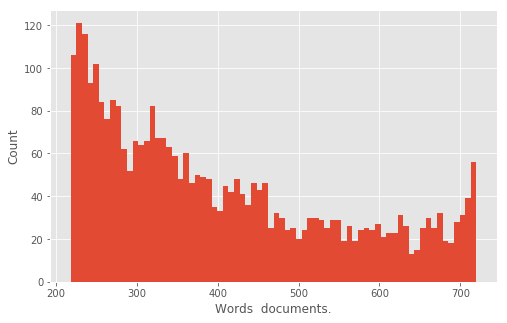

In [18]:
### DEFACTORING INSPECTION
plt.style.use('ggplot')
ax = pd.Series([x[1] for x in wordcounts.most_common(n=3200)]).hist(
    bins=72, 
    figsize=(8,5))
ax.set_xlabel("Words  documents.")
ax.set_ylabel("Count")
plt.show()

The plot above shows a histogram of the top 3,200 words and how they are expressed across corpus. The spike on the right end of this chart shows there are nearly 60 words that appear in all 720 documents (as we can see in the text table above). As a whole, the higher bars on the left side of the chart indicate most of the words appear in a smaller number of documents. Here we use defactoring as a technique to investigate and even generate intermediate representations of the data, representations implicit in the data structures created by Underwood and Sellers, but not explicitly visualized in their narrative. For our purposes, this image is an interesting chapter in the story of the data precisely because it is in the middle of Underwood and Seller’s analysis. These middle states are often glossed over in the hurried rush for analysis to generate a meaningful result. Defactoring is an effort to slow down, take a breather, and reflect upon the data-work that has happened up until this point in the code. The meandering step-by-step journey through the code sometimes reveals very interesting paths not taken, such as the commented out code block below.

In [19]:
# vocablist = binormal_select(vocablist, positivecounts, negativecounts, totalposvols, totalnegvols, 3000)
# Feature selection is deprecated. There are cool things
# we could do with feature selection,
# but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
# The tradeoff isn't worth it. Explanation is more important.
# So we just take the most common words (by number of documents containing them)
# in the whole corpus. Technically, I suppose, we could crossvalidate that as well,
# but *eyeroll*.

The author’s code above does not actually perform any work as each line has been commented out, however we include it because it points towards an execution path not taken and an interesting rationale for why it was not followed. In the “production” code the heuristic for feature selection is to simply select the 3200 most common words by their appearance in the 720 documents. This is a simple and easy technique to implement and–more importantly–explain to a literary history and digital humanities audience. Selecting the top words is a well established practice in text analysis and it has a high degree of methodologically face validity. It is a good mechanism for removing features that have diminishing returns. However, the commented code above tells a different, and methodologically significant, story.
The comment discusses an alternative technique for feature selection using binormal selection. Because this function is commented out and not used in the analysis, we have opted to not include it as part of the defactoring. Instead, we have decided to focus on the more interesting rationale about why binormal selection is not being used in the analysis as indicated in the author’s comments:

> There are cool things we could do with feature selection, but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
> The tradeoff isn't worth it. Explanation is more important.

This comment reveals much about the reasoning, the effort, and energy focused on the important, but in the humanities oft neglected, work of discussing methodology. As Underwood argued in *The literary uses of high-dimensional space* (Underwood 2015b), while there is enormous potential for the application of statistical methods in humanistic fields like literary history there is resistance to these methods because there is a resistance to methodology. Underwood has described the humanities disciplines relationship to methodology as an “insistence on staging methodology as ethical struggle” (Underwood 2013). In this commented code we can see the material manifestation of Underwood’s sentiment, in this case embodied by self-censorship in the decision to not use more statistically robust techniques for feature selection. We do not argue this choice compromises the analysis or final conclusions, rather we want to highlight the practical and material ways a resistance to plurality in research methods manifests in the digital humanities. By focusing on a close reading of the code and execution environment, by *defactoring*, we provide a methodology to assist with the omnipresent *explanatory* task commensurate with the use of computational research methods in the humanities.

In an algorithmic, data driven analysis, the selection of features is a *crucial* step because it affects the accuracy of the algorithm. In the digital humanities, feature selection is deeply embedded in the theory of the analysis and the context of the data. Claims made in and through this kind of analysis must attend to the representational configuration of the data. That is to say, we cannot take for granted how we have transformed data and what data are included or excluded from the analysis. Care, in the form of thorough documentation and thoughtful reflection, must be taken–especially at this unique moment in the development of digital humanities as we are still learning how algorithmic, data-driven techniques can be leveraged to better understand our objects of study. 

#### Filtering Authors

In [20]:
donttrainon = list()

# Here we create a list of volumed IDs not to be used for training.
# For instance, we have supplemented the dataset with volumes that
# are in the Norton but that did not actually occur in random
# sampling. We want to make predictions for these, but never use
# them for training.

for idx1, anid in enumerate(orderedIDs):
    reviewedstatus = metadict[anid]['reviewed']
    date = infer_date(metadict[anid], datetype)
    if reviewedstatus == 'addedbecausecanon':
        donttrainon.append(idx1)
    elif date < pastthreshold or date > futurethreshold:
        donttrainon.append(idx1)

As the comments describe, this block of code creates a list of volume IDs not to be used in the training. What that means *in code* is that any volume with the metadata label `addedbecauseofcanon` or with a date outside of the thresholds defined by `pastthreshold` and `futurethreshold` will be ignored. If we inspect the `donttrainon` variable we can see how many volumes satisfy these criteria.

In [21]:
### DEFACTORING INSPECTION
print("The variable donttrainon contains {} volume IDs".format(
    len(donttrainon)))

The variable donttrainon contains 0 volume IDs


It would appear there are no volumes to be filtered out by these criteria.

In [22]:
authormatches = [list(donttrainon) for x in range(len(orderedIDs))]
# For every index in authormatches, identify a set of indexes that have
# the same author. Obvs, there will always be at least one.

# Since we are going to use these indexes to exclude rows, we also add
# all the ids in donttrainon to every volume

for idx1, anid in enumerate(orderedIDs):
    thisauthor = metadict[anid]['author']
    for idx2, anotherid in enumerate(orderedIDs):
        otherauthor = metadict[anotherid]['author']
        if thisauthor == otherauthor and not idx2 in authormatches[idx1]:
            authormatches[idx1].append(idx2)

for alist in authormatches:
    alist.sort(reverse = True)

# I am reversing the order of indexes so that I can delete them from
# back to front, without changing indexes yet to be deleted.
# This will become important in the modelingprocess module.

In this block of code Underwood and Sellers group the volumes by the same author. The list `authormatches` is a list of lists for each volume. Each sub-list contains the IDS of all the volumes by the same author. Essentially this data structure represents the potential relations of each volume to other volumes, with that relation being “other volumes by the same author.” This raises the question, how many volumes share the same author in this corpus.

In [23]:
### DEFACTORING INSPECTION
# Tabular view of shared authorship
pd.Series([len(x) for x in authormatches]).value_counts()

1    579
2     82
3     30
5     15
4      8
6      6
dtype: int64

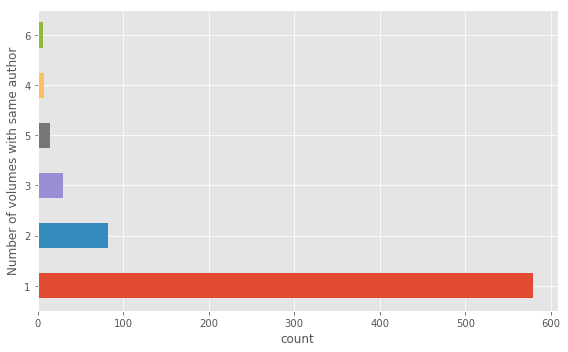

In [24]:
### DEFACTORING INSPECTION
# Barchart of shared authorship
ax = (pd.Series([len(x) for x in authormatches])
      .value_counts()
      .plot(kind="barh",
           figsize=(8,5)))
ax.set_xlabel("count")
ax.set_ylabel("Number of volumes with same author")
plt.tight_layout()

This histogram tells us a majority of volumes are written by unique authors but that there are some authors who have written up to six volumes in the corpus. Note, we are generating this graph by counting the length of the list containing the volume IDs of other volumes by the same author. This means volumes written by the same author are counted twice. This is not an issue for the purposes of our inspection, just that the sum total number of volumes represented by this histogram is greater than 720.

#### Filtering Words

In [25]:
### DEFACTORING DEFINITIONS

usedate = False
# Leave this flag false unless you plan major
# surgery to reactivate the currently-deprecated
# option to use "date" as a predictive feature.

def get_features(wordcounts, wordlist):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    return wordvec

# In an earlier version of this script, we sometimes used
# "publication date" as a feature, to see what would happen.
# In the current version, we don't. Some of the functions
# and features remain, but they are deprecated. E.g.:

def get_features_with_date(wordcounts, wordlist, date, totalcount):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords + 1)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    wordvec = wordvec / (totalcount + 0.0001)
    wordvec[numwords] = date
    return wordvec

This code cell defines two functions to be used below when opening and parsing the raw data files (in the `poems/` directory). The function `get_features()` simply takes the word counts from the parsed volume and filters out any words that are not part of `wordlist`, which contains the list of word features that had been selected for this analysis. We have also included a second function, `get_features_with_date()`, even though it is not executed. This residual code points to yet another path not taken, one that uses the volume’s publication date as a feature. As Underwood and Seller’s comment indicates, this was an experiment from an “earlier version of this script...to see what would happen.”

In [26]:
volsizes = dict()
voldata = list()
classvector = list()

for volid, volpath in volspresent:

    with open(volpath, encoding = 'utf-8') as f:
        voldict = dict()
        totalcount = 0
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 2 or len(fields) < 2:
                continue

            word = fields[0]
            count = int(fields[1])
            voldict[word] = count
            totalcount += count

    date = infer_date(metadict[volid], datetype)
    date = date - 1700
    if date < 0:
        date = 0

    if usedate:
        features = get_features_with_date(voldict, 
                                          vocablist, 
                                          date, 
                                          totalcount)
        voldata.append(features)
    else:
        features = get_features(voldict, vocablist)
        voldata.append(features / (totalcount + 0.001))


    volsizes[volid] = totalcount
    classflag = classdictionary[volid]
    classvector.append(classflag)
    
data = pd.DataFrame(voldata)

This is an important code block because we are now pulling the raw data files from the poems/ directory into memory, filtering out the unselected word features, and putting the data into a vectorized data structure. The code loops over the `volspresent` variable and parses each individual volume into the `voldict` dictionary. At this stage the code is reading in all the words of a volume including their frequencies, and it is tabulating the total number of words in that volume. Once all of the data for the volume has been read into memory, the code calls the `get_features` function that throws out the words not part of the selected word features stored in the `vocablist` variable. This is where the top 3200 words are foregrounded and the remaining, less commonly used words, are discarded.

At this point, any prosaic resemblance left in the data is gone and now we are dealing entirely with textual data in a numeric form.

In [27]:
### DEFACTORING INSPECTION
print("The vector representation of {} by {}".format(
    metadict[defactoring_volume_id]['title'], 
    metadict[defactoring_volume_id]['author']))
print("The vector has a length of {}.".format(
    len(features)))
print("The first 100 elements of the vector:")
print(features[0:100])

The vector representation of The croakers by Drake, Joseph Rodman,
The vector has a length of 3200.
The first 100 elements of the vector:
[ 199.  146.  885.  562.  176. 1152.  509.  195.  215.  956.  288.  156.
  215.  200.  215.  159.  149. 2043.  222.   92.  171.  457.  162.  113.
  146.  118.  335.   84.  181.   93.  102.  258.   65.  159.   79.  135.
   72.   95.   61.   70.   84.   45.   73.   40.   44.   38.   88.   35.
   73.   59.   74.  100.   76.   29.   54.   55.   40.   48.   51.   54.
   21.   58.   37.   60.   63.   34.   40.   24.   63.   55.   11.   79.
   28.   47.   21.   28.   39.   19.   15.   30.   44.   15.   23.   25.
   81.   60.   33.   17.   15.   67.   33.   55.   31.   22.   55.   26.
   35.   40.   14.  117.]


The inspection above shows us the last volume processed by the loop, *The Croakers* by Joseph Rodman Drake. As we can see, the words for this volume of poetry are now represented as a list of numbers (representing word frequencies). However, this list of numbers still requires additional transformation in order to be consumable by logistic regression. The word frequencies need to be normalized so they are comparable across volumes. To do this Underwood and Sellers divide the frequency of each individual word (each number in the list above) by the total number of words in that volume (the `totalcount` variable. This makes volumes of different lengths comparable by turning absolute frequencies into relative frequencies. One thing we initially did not understand is why the value of 0.001 has been added to the `totalcount` variable. When we asked, it turned out this is a “lazy” way to prevent divide-by-zero errors.

The end result of the code we have executed thus far in the notebook is a very neat and tidy table of numbers between zero and 1.

In [28]:
### DEFACTORING INSPECTION
# Normalized perspective of the data
data.tail()

0         1         2         3         4         5         6     \
715  0.006064  0.004322  0.012832  0.014809  0.005595  0.038597  0.016082   
716  0.006234  0.004711  0.013610  0.015704  0.003997  0.045541  0.022842   
717  0.003002  0.003458  0.020750  0.018532  0.005024  0.042088  0.009266   
718  0.007437  0.004857  0.011535  0.011839  0.003643  0.019200  0.012370   
719  0.004548  0.003337  0.020227  0.012845  0.004022  0.026329  0.011633   

         7         8         9       ...         3190      3191      3192  \
715  0.007203  0.003752  0.020337    ...     0.000034  0.000000  0.000067   
716  0.006091  0.002379  0.020320    ...     0.000048  0.000048  0.000000   
717  0.007243  0.001436  0.021403    ...     0.000000  0.000000  0.000000   
718  0.004326  0.003794  0.022236    ...     0.000000  0.000152  0.000076   
719  0.004457  0.004914  0.021849    ...     0.000000  0.000000  0.000000   

         3193      3194      3195  3196      3197      3198      3199  
715  0.000000  0.000067  0.000000   0.0  0.000000  0.000034  0.000000  
716  0.000000  0.000143  0.000048   0.0  0.000143  0.000000  0.000048  
717  0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000261  
718  0.000000  0.000000  0.000000   0.0  0.000076  0.000000  0.000000  
719  0.000023  0.000046  0.000023   0.0  0.000000  0.000000  0.000069  

[5 rows x 3200 columns]

The last row in that table, 719, is the volume we have been tracking, *The Croakers* by Joseph Rodman Drake. It is just one of 720 relatively indistinguishable rows of numbers in this representation of 19th century poetry. This is a radical transformation of the original, prosaic representation literary historians are probably used to seeing:

![Screenshot of the Google Books site for The Croakers](notebook_resources/the-croakers.png)

In [29]:
sextuplets = list()
for i, volid in enumerate(orderedIDs):
    listtoexclude = authormatches[i]
    asixtuple = (data, 
                 classvector, 
                 listtoexclude, 
                 i, 
                 usedate, 
                 regularization)
    sextuplets.append(asixtuple)

This is the last step before Underwood and Sellers’s code moves away from the transformation of features and into the actual analysis of the data. This bit of code gathers all of the relevant data and metadata that has been cleaned and normalized in a structure suitable for performing the statistical analysis. The `sextuplets` variable is a list of 720 tuples containing six elements. Each item in the `sextuplets` list contains the necessary data structures to model each poem. The contents of each item in the list is as follows:

- `data`: a normalized feature matrix. Word features are the columns and volumes are the rows with dimensions of 720 x 3200.
- `classvector`: the classification or labels of volumes as either 'reviewed' (1) or 'random' (0).
- `listtoexclude`: the list of poems to ignore because they are the same author.
- ``i: the index of the volume
- `usedate`: a flag indicating if date is a feature. It is false in this analysis.
- `regularization`: a parameter for the logistic regression. This value was hardcoded at the beginning of the code in the Setting Parameters section.

With all of the data assembled and in the right shape, a process we call *data fitness*, we can now venture into the algorithmic territory and perform the statistical analysis. As we can see, the *fitted* representation of features has traveled a great distance from the original poetry. One of the most important aspects of *distant reading* is the work of cleaning, preparing, and normalizing texts to be "read" by an algorithm. When considering distance, we should think not only of the perspective that we, the analyst, are reading from, but also the distance traveled in terms of successive transformations and representations of the data. If computational literary history is a triathalon, we have only completed the first endurance test.

### Training Predictive Models

We are now about to dive into the very heart of the analysis, training predictive models on each volume. The code cells below do the following:


- Iterate over every volume in the corpus. For each volume, do the following:
    - Create a training set by removing the selected volume and other volumes by the same author from the corpus (performed by the `sliceframe()` function). In the language of predictive modeling, the removed volume is the “held out” data.
    - Normalize the training data by computing the z-score for each feature/feature set (performed by the `normalizearray()` function).
    - Fit the model on the training data (performed by the `model_one_volume()` function).
    - Use the fitted model to predict the probability the (normalized) held out data was "reviewed" or "random."
    
What is important to understand is that this section of the code does not train a single model, rather it trains 720 independent models–one for each volume. This process is called “leave-one-out” cross validation. As the code loops over the volumes, it holds out one volume, trains the model on all of the remaining volumes, and then uses that model to predict the status of the held out volume. Lather, Rinse, Repeat.

In [30]:
### DEFACTORING DEFINITION

def sliceframe(dataframe, yvals, excludedrows, testrow):
    numrows = len(dataframe)
    newyvals = list(yvals)
    for i in excludedrows:
        del newyvals[i]
        # NB: This only works if we assume that excluded rows
        # has already been sorted in descending order !!!!!!!
        # otherwise indexes will slide around as you delete

    trainingset = dataframe.drop(dataframe.index[excludedrows])

    newyvals = np.array(newyvals)
    testset = dataframe.iloc[testrow]

    return trainingset, newyvals, testset

This function prepares the data for training one model by separating volumes used for training from a single volume held out to test the predictive power of the model. The function takes a dataframe containing the feature vectors, a list of the classifications for each volume, a list of volumes to exclude (because of shared authorship), and the the index of the specific volume to be held out. It returns the dataframe with the held out volume removed (`trainingset`), a list of the known classifications (`newyvals`) corresponding to the training set, and the held-out volume that will be classified once the model has been trained (`testset`).

In [31]:
### DEFACTORING DEFINITION

def normalizearray(featurearray, usedate):
    '''Normalizes an array by centering on means and
    scaling by standard deviations. Also returns the
    means and standard deviations for features.
    '''

    numinstances, numfeatures = featurearray.shape
    means = list()
    stdevs = list()
    lastcolumn = numfeatures - 1
    for featureidx in range(numfeatures):

        thiscolumn = featurearray.iloc[ : , featureidx]
        thismean = np.mean(thiscolumn)

        thisstdev = np.std(thiscolumn)

        if (not usedate) or featureidx != lastcolumn:
            # If we're using date we don't normalize the last column.
            means.append(thismean)
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
        else:
            print('FLAG')
            means.append(thismean)
            thisstdev = 0.1
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
            # We set a small stdev for date.

    return featurearray, means, stdevs

This function standardizes the features by computing the z-score for the feature vectors. That is, it loops over each column of the data, subtracts the column mean from each value, and then divides that value by the standard deviation. This is an important step in the data preparation pipeline because it ensures all of the data values are on the same scale.

In [32]:
### DEFACTORING DEFINITION

def model_one_volume(data5tuple):
    data, classvector, listtoexclude, i, usedate, regularization = \
        data5tuple
    trainingset, yvals, testset = sliceframe(data, 
                                             classvector, 
                                             listtoexclude, 
                                             i)
    newmodel = LogisticRegression(C = regularization)
    trainingset, means, stdevs = normalizearray(trainingset, usedate)
    newmodel.fit(trainingset, yvals)

    testset = (testset - means) / stdevs
    prediction = newmodel.predict_proba(testset.values.reshape(1, -1))[0][1]
    if i % 50 == 0:
        print(i)
    # print(str(i) + "  -  " + str(len(listtoexclude)))
    return prediction

In many respects, this is the most salient block of code in the entire document. The code above actually runs the logistic regression and does the algorithmic work that generates a prediction about each individual volume. This function builds upon the two previous functions to assemble a normalized set of training data (`trainingset`) distinct from the single volume to be predicted (`testset`).

There are three lines of code involved in the computational modeling of the data. First, Underwood and Sellers instantiate a model object with the regularization parameter (more on that below):
```
newmodel = LogisticRegression(C = regularization)
```
Then they “fit” the model using the normalized training data:
```
newmodel.fit(trainingset, yvals)
```
Once a model has been “fit” to the data they can use that model to make predictions about unseen or held-out data. This is what they do with the `predict_proba()` function in this line:
```
prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1]
```
Those three lines are all it takes to do the computational part of of the analysis, the rest of the code up until this point has all been data preparation, cleaning, normalization, and re-shaping. This ratio of analytical to preparative code is interesting and indicates that claims that machines are eradicating scholars’ jobs are greatly exaggerated (Basken 2017).

#### Regularization and Logistic Regression

The three lines of code above hide a significant amount of intellectual and computational work. The call to the `newmodel.fit()` function is a crucial step in the analytical process. Underwood and Sellers are using an implementation of Logistic Regression from the 3rd party Python library scikit-learn.

At a very high level, logistic regression is a machine learning algorithm for performing classification. Logistic regression works by estimating the parameters of a function, the *hypothesis representation*, that divides a multidimensional space into two parts (note, in this case we are talking about binomial or binary logistic regression, which classifies things into one of two bins). The hypothesis representation describes a line that winds its way through the space creating what is called the *decision boundary*. Every data point that lands on one side the boundary gets one label and every data point on the other side of the boundary gets the other label. Similar to linear regression, the goal is to find the best hypothesis representation, that is, the function that best draws a line dividing the space given the known data points. Once you have a good hypothesis representation, an appropriately *fit* model, you can begin to classify *new* data by dropping data points into the multidimensional space and seeing on which side of the decision boundary they land.

The key to logistic regression is estimating the parameters of the hypothesis representation–the parameters to the function that draws a line through the multidimensional space. We can derive the parameters by using the *features* of existing data combined with their known labels; this is called *training data*. The modeling process is executed by the function call to `newmodel.fit(trainingset, yvals)`. In Underwood and Sellers’s code the model uses the training data—the matrix of word features in the data variable and known labels (‘reviewed’ or ‘random’) in the classvector variable—to “learn” the parameters through a process called *coordinate descent*. How so-called optimization functions  work is well beyond the scope of the discussion.

#### Overfitting

One of the problems when fitting a logistic regression model is a tendency towards *overfitting*. Crudely this means the model, the function with the learned parameters, that you estimated have tailored themselves such that they are overly optimized to the particular training data you provided. As such, the model becomes less useful for prediction or classifying new data because they are outside the fitness of the model. An overfit model is like a snug pair of jeans, once you put on a few pounds (add new data) they don’t fit. In Underwood and Sellers’s case, they are fitting models on all volumes except one, which is held out. Then they test the predictive performance of the model by seeing if it correctly classifies the held-out volume. If they overfit the models, the model will to a terrible job guessing the status of the held out volumes.

When Underwood and Sellers instantiated the model (`newmodel = LogisticRegression(C = regularization)`), they set a regularization parameter on the model. Regularization is a technique for logistic regression (and other machine learning algorithms) that smooths out the tendency toward overfitting with some more mathematical gymnastics. The diagram below shows how regularization can help with the fitness of the model:

![Regularization](notebook_resources/regression_figures.png)
*On the left side is a linear regression which doesn’t quite fit the data. In the middle is an overfit logistic regression. On right side is a regularized logistic regression.*

As the diagrams show, the regularized logistic expression (the right side) does have a bit of error, there are pink and blue dots on the wrong sides of the decision boundary, but as more data get added it will generally be more right than the overfitted model as represented by the middle diagram (the squiggly decision boundary).

#### Running the Regression

In [33]:
# Now do leave-one-out predictions.
print('Beginning multiprocessing.')

pool = Pool(processes = 4)
res = pool.map_async(model_one_volume, sextuplets)

# After all files are processed, write metadata, errorlog, and counts of phrases.
res.wait()
resultlist = res.get()

assert len(resultlist) == len(orderedIDs)

logisticpredictions = dict()
for i, volid in enumerate(orderedIDs):
    logisticpredictions[volid] = resultlist[i]

pool.close()
pool.join()

print('Multiprocessing concluded.')

Beginning multiprocessing.
0
50
100
150
200
250
300
350
450
500
400
550
600
650
700
Multiprocessing concluded.


This code automates the training of 720 volumes, holding out one volume, training the model on the remaining volumes, and then making a prediction for the held-out volume. As a very computation intensive process training or fitting a logistic regression model takes time, and training 720 different models obviously takes 720 times longer. Fortunately, this is a so called embarrassingly parallel computational task and so we can train the models using parallel processing instead of one after the other. Using Python’s built in parallel processing modules, this code can speed up the process. Still, this block of code takes a fair amount of time to execute, around twenty minutes on a quad core MacBook Pro (late 2013 model). 

In [34]:
### DEFACTORING INSPECTION
print("There are {} predictions.".format(len(logisticpredictions)))


There are 720 predictions.


What emerges from the other side of this computationally intensive task are a series of predictions, 720 to be specific, one for each of the modeled volumes. These predictions, stored in the `logisticpredictions` variable, are the model’s assertions of each volume’s reviewed status. Additionally, because we already know the status of the modeled volumes we can compare the performance of the predictive model to the “ground truth” and see if the algorithm was able to detect patterns.

In [35]:
truepositives = 0
truenegatives = 0
falsepositives = 0
falsenegatives = 0
allvolumes = list()

with open(outputpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['volid', 
              'reviewed', 
              'obscure', 
              'pubdate', 
              'birthdate', 
              'gender', 
              'nation', 
              'allwords', 
              'logistic', 
              'author', 
              'title', 
              'pubname', 
              'actually', 
              'realclass']
    writer.writerow(header)
    for volid in IDsToUse:
        metadata = metadict[volid]
        reviewed = metadata['reviewed']
        obscure = metadata['obscure']
        pubdate = infer_date(metadata, datetype)
        birthdate = metadata['birthdate']
        gender = metadata['gender']
        nation = metadata['nation']
        author = metadata['author']
        title = metadata['title']
        canonicity = metadata['canonicity']
        pubname = metadata['pubname']
        allwords = volsizes[volid]
        logistic = logisticpredictions[volid]
        realclass = classdictionary[volid]
        outrow = [volid, 
                  reviewed, 
                  obscure, 
                  pubdate,
                  birthdate, 
                  gender, 
                  nation, 
                  allwords, 
                  logistic, 
                  author, 
                  title, 
                  pubname, 
                  canonicity, 
                  realclass]
        writer.writerow(outrow)
        allvolumes.append(outrow)

        if logistic > 0.5 and classdictionary[volid] > 0.5:
            truepositives += 1
        elif logistic <= 0.5 and classdictionary[volid] < 0.5:
            truenegatives += 1
        elif logistic <= 0.5 and classdictionary[volid] > 0.5:
            falsenegatives += 1
        elif logistic > 0.5 and classdictionary[volid] < 0.5:
            falsepositives += 1

This code is a bit simpler than its predecessors. This block writes a CSV file to disk containing 720 rows of volume metadata, the predicted classification, and the actual classification.  

### Modeling Coefficients

The code below generates a single logistic regression model, trained on all of the data with nothing held-out. The properties of this model, the coefficients of the hypothesis representation, are interrogated to better understand the influence of individual features, words, on reviewed or unreviewed volumes. Thus this individual model is not using computational modeling to predict a phenomena, it is using the computational model to explore and explain patterns and features of the phenomena.

In [36]:
donttrainon.sort(reverse = True)
trainingset, yvals, testset = sliceframe(data, 
                                         classvector, 
                                         donttrainon, 
                                         0)
newmodel = LogisticRegression(C = regularization)
trainingset, means, stdevs = normalizearray(trainingset, usedate)
newmodel.fit(trainingset, yvals)

coefficients = newmodel.coef_[0] * 100

coefficientuples = list(zip(coefficients, 
                            (coefficients / np.array(stdevs)), 
                            vocablist + ['pub.date']))
coefficientuples.sort()
if verbose:
    for coefficient, normalizedcoef, word in coefficientuples:
        print(word + " :  " + str(coefficient))

print()
accuracy = (truepositives + truenegatives) / len(IDsToUse)

This code functions much like the code in the `model_one_volume(`) function except it only trains a single model for the purposes of investigating the impact of particular words on the prediction. By inspecting the magnitude of the coefficients Underwood and Sellers can see how particular words influenced a positive or negative prediction. Looking at the code, specifically the call to `sliceframe()` reveals this model actually does have some hold-out data, the first volume at index zero. We suspect the cost of excluding a single volume is less than the effort of re-implementing the `sliceframe()` function. The code to instantiate and train the model is identical to the code above, but instead of predicting the status of the held-out data the code extracts the coefficients from the model and puts them in the `coefficients` variable.

In [37]:
### DEFACTORING INSPECTION
print("There are {} coefficients in this model.".format(len(coefficientuples)))

There are 3200 coefficients in this model.


In [38]:
### DEFACTORING INSPECTION
print("First ten items in the list of coefficients.")
coefficientuples[:10]

First ten items in the list of coefficients.


[(-0.451744515308058, -1531.5503056343666, "i'll"),
 (-0.42711374653208284, -7254.811741867888, 'mission'),
 (-0.4116879738928419, -862.7068493207225, 'tis'),
 (-0.37939299320003567, -1125.1778023608326, 'oft'),
 (-0.3783134051280357, -3337.335314702983, 'greet'),
 (-0.37399562365121103, -2558.9492503627807, 'wondrous'),
 (-0.3712630706903529, -222.8852087160384, 'our'),
 (-0.3695437312947107, -4356.707179481598, 'anxious'),
 (-0.35904965455922144, -2087.1252362010537, 'cheer'),
 (-0.35632804949908553, -1383.450564130784, "we'll")]

In [39]:
### DEFACTORING INSPECTION
print("Last ten items in the list of coefficients.")
coefficientuples[-10:]

Last ten items in the list of coefficients.


[(0.3726635222640156, 4799.590619119897, 'brows'),
 (0.381170570302538, 224.41690606199722, 'not'),
 (0.3825388340735533, 1149.152152033426, 'half'),
 (0.38439578227360166, 398.793247462678, 'what'),
 (0.38473402074228275, 6977.874918531145, 'whereon'),
 (0.39921722974326485, 3171.5809993565736, 'sake'),
 (0.403144385914046, 2023.7759161873807, 'slow'),
 (0.40674741624813554, 3933.908677099459, 'hollow'),
 (0.41261956910143927, 1531.930520538605, 'black'),
 (0.4525125027699761, 615.0067489318402, 'eyes')]

The coefficients are a list of numbers, one per word feature, that determine the shape of the line through the multidimensional space. These results tell us the influence of particular words in the classification of volumes in the corpus. Looking at the normalized values helps us understand the degree to which particular words are more or less associated with reviewed or unreviewed poetry.

In [40]:
coefficientpath = outputpath.replace('.csv', '.coefs.csv')
with open(coefficientpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    for triple in coefficientuples:
        coef, normalizedcoef, word = triple
        writer.writerow([word, coef, normalizedcoef])


### DEFACTORING NAMESPACE
rawaccuracy = accuracy 

This code generates the `mainmodelcoefficients.csv` output file, which contains the word, its coefficient, and its normalized coefficients.

### Plotting Results

The final function of the analysis is to test the accuracy of the model(s). This code produces a plot giving a sense of how the model performed compared to the known classifications.

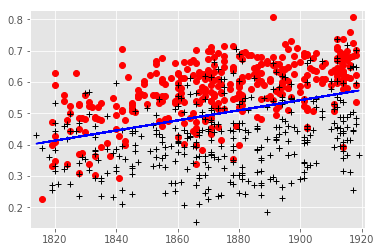

If we divide the dataset with a horizontal line at 0.5, accuracy is:  0.7736111111111111
Divided with a line fit to the data trend, it's  0.7916666666666666


In [41]:
### DEFACTORING FUNCTION PARAMETERS
modeltype = 'linear'
datelimits = []
''' Takes a set of predictions produced by a model that knows nothing about date,
and divides it along a line with a diachronic tilt. We need to do this in a way
that doesn't violate crossvalidation. I.e., we shouldn't "know" anything
that the model didn't know. We tried a couple of different ways to do this, but
the simplest and actually most reliable is to divide the whole dataset along a
linear central trend line for the data!
'''



listofrows = list()
classvector = list()

# DEPRECATED
# if modeltype == 'logistic' and len(datelimits) == 2:
#     # In this case we construct a subset of data to model on.
#     tomodeldata = list()
#     tomodelclasses = list()
#     pastthreshold, futurethreshold = datelimits

for volume in allvolumes:
    date = volume[3]
    logistic = volume[8]
    realclass = volume[13]
    listofrows.append([logistic, date])
    classvector.append(realclass)

    # DEPRECATED
    # if modeltype == 'logistic' and len(datelimits) == 2:
    #     if date >= pastthreshold and date <= futurethreshold:
    #         tomodeldata.append([logistic, date])
    #         tomodelclasses.append(realclass)

y, x = [a for a in zip(*listofrows)]
plt.axis([min(x) - 2, max(x) + 2, min(y) - 0.02, max(y) + 0.02])
reviewedx = list()
reviewedy = list()
randomx = list()
randomy = list()

for idx, reviewcode in enumerate(classvector):
    if reviewcode == 1:
        reviewedx.append(x[idx])
        reviewedy.append(y[idx])
    else:
        randomx.append(x[idx])
        randomy.append(y[idx])

plt.plot(reviewedx, reviewedy, 'ro')
plt.plot(randomx, randomy, 'k+')

if modeltype == 'logistic':
    # all this is DEPRECATED
    print("Hey, you're attempting to use the logistic-tilt option")
    print("that we deactivated. Go in and uncomment the code.")

    # if len(datelimits) == 2:
    #     data = pd.DataFrame(tomodeldata)
    #     responsevariable = tomodelclasses
    # else:
    #     data = pd.DataFrame(listofrows)
    #     responsevariable = classvector

    # newmodel = LogisticRegression(C = 100000)
    # newmodel.fit(data, responsevariable)
    # coefficients = newmodel.coef_[0]

    # intercept = newmodel.intercept_[0] / (-coefficients[0])
    # slope = coefficients[1] / (-coefficients[0])

    # p = np.poly1d([slope, intercept])

elif modeltype == 'linear':
    # what we actually do

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope = z[0]
    intercept = z[1]

plt.plot(x,p(x),"b-")
plt.show(block = False)

x = np.array(x, dtype='float64')
y = np.array(y, dtype='float64')
classvector = np.array(classvector)
dividingline = intercept + (x * slope)
predicted_as_reviewed = (y > dividingline)
really_reviewed = (classvector == 1)

accuracy = sum(predicted_as_reviewed == really_reviewed) / len(classvector)

### DEFACTORING NAMESPACE
tiltaccuracy = accuracy 

print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', 
      str(rawaccuracy))

print("Divided with a line fit to the data trend, it's ", 
      str(tiltaccuracy))

The code above generates a best fit line for all of the results. Underwood and Sellers then selects the predicted-as-reviewed volumes, which are the volumes falling above the dividing line. The accuracy of the dividing line is the ratio between the total number of volumes predicted-as-reviewed and the number of actually reviewed volumes. Note that this is the accuracy of the dividing line, not the accuracy of the model(s) to predict the reviewed status of the poems.